# Neural Nets with Keras

In this notebook you will learn how to implement neural networks using the Keras API. We will use TensorFlow's own implementation, *tf.keras*, which comes bundled with TensorFlow.

Don't hesitate to look at the documentation at [keras.io](https://keras.io/). All the code examples should work fine with tf.keras, the only difference is how to import Keras:

```python
# keras.io code:
from keras.layers import Dense
output_layer = Dense(10)

# corresponding tf.keras code:
from tensorflow import keras
Dense = keras.layers.Dense
output_layer = Dense(10)

# or simply:
from tensorflow import keras
output_layer = keras.layers.Dense(10)
```

In this notebook, we will not use any TensorFlow-specific code, so everything you see would run just the same way on [keras-team](https://github.com/keras-team/keras) or any other Python implementation of the Keras API (except for the imports).

## Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
matplotlib 3.0.2
numpy 1.15.4
pandas 0.23.4
sklearn 0.20.1
tensorflow 2.0.0-dev20190126
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [4]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

**Note**: The preview version of TensorFlow 2.0 shows up as version 1.13. That's okay. To test that this behaves like TF 2.0, we verify that `tf.function()` is present.

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 1 – TensorFlow Playground

Visit the [TensorFlow Playground](http://playground.tensorflow.org).
* **Layers and patterns**: try training the default neural network by clicking the "Run" button (top left). Notice how it quickly finds a good solution for the classification task. Notice that the neurons in the first hidden layer have learned simple patterns, while the neurons in the second hidden layer have learned to combine the simple patterns of the first hidden layer into more complex patterns). In general, the more layers, the more complex the patterns can be.
* **Activation function**: try replacing the Tanh activation function with the ReLU activation function, and train the network again. Notice that it finds a solution even faster, but this time the boundaries are linear. This is due to the shape of the ReLU function.
* **Local minima**: modify the network architecture to have just one hidden layer with three neurons. Train it multiple times (to reset the network weights, just add and remove a neuron). Notice that the training time varies a lot, and sometimes it even gets stuck in a local minimum.
* **Too small**: now remove one neuron to keep just 2. Notice that the neural network is now incapable of finding a good solution, even if you try multiple times. The model has too few parameters and it systematically underfits the training set.
* **Large enough**: next, set the number of neurons to 8 and train the network several times. Notice that it is now consistently fast and never gets stuck. This highlights an important finding in neural network theory: large neural networks almost never get stuck in local minima, and even when they do these local optima are almost as good as the global optimum. However, they can still get stuck on long plateaus for a long time.
* **Deep net and vanishing gradients**: now change the dataset to be the spiral (bottom right dataset under "DATA"). Change the network architecture to have 4 hidden layers with 8 neurons each. Notice that training takes much longer, and often gets stuck on plateaus for long periods of time. Also notice that the neurons in the highest layers (i.e. on the right) tend to evolve faster than the neurons in the lowest layers (i.e. on the left). This problem, called the "vanishing gradients" problem, can be alleviated using better weight initialization and other techniques, better optimizers (such as AdaGrad or Adam), or using Batch Normalization.
* **More**: go ahead and play with the other parameters to get a feel of what they do. In fact, after this course you should definitely play with this UI for at least one hour, it will grow your intuitions about neural networks significantly.

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 2 – Image classification with tf.keras

### Load the Fashion MNIST dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

The training set contains 55,000 grayscale images, each 28x28 pixels:

In [ ]:
X_train.shape

Each pixel intensity is represented by a uint8 (byte) from 0 to 255:

In [ ]:
X_train[0]

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [ ]:
y_train

Here are the corresponding class names:

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [ ]:
class_names[y_train[0]]

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [ ]:
X_valid.shape

In [ ]:
X_test.shape

Let's take a look at a sample of the images in the dataset:

In [ ]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

This dataset has the same structure as the famous MNIST dataset (which you can load using `keras.datasets.mnist.load_data()`), except the images represent fashion items rather than handwritten digits, and it is much more challenging. A simple linear model can reach 92% accuracy on MNIST, but only 83% on fashion MNIST.

### Build a classification neural network with Keras

### 2.1)
Build a `Sequential` model (`keras.models.Sequential`), without any argument, then and add four layers to it by calling its `add()` method:
  * a `Flatten` layer (`keras.layers.Flatten`) to convert each 28x28 image to a single row of 784 pixel values. Since it is the first layer in your model, you should specify the `input_shape` argument, leaving out the batch size: `[28, 28]`.
  * a `Dense` layer  (`keras.layers.Dense`) with 300 neurons (aka units), and the `"relu"` activation function.
  * Another `Dense` layer with 100 neurons, also with the `"relu"` activation function.
  * A final `Dense` layer with 10 neurons (one per class), and with the `"softmax"` activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [ ]:
model = keras.models.Sequential()
model.add(layer=keras.layers.Flatten(input_shape=[28, 28]))
model.add(layer=keras.layers.Dense(units=300, activation='relu'))
model.add(layer=keras.layers.Dense(units=100, activation='relu'))
model.add(layer=keras.layers.Dense(units=100, activation='softmax'))
print(model)

### 2.2)
Alternatively, you can pass a list containing the 4 layers to the constructor of the `Sequential` model. The model's `layers` attribute holds the list of layers.

In [ ]:
model = keras.models.Sequential(layers=[
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(units=300, activation='relu'),
    keras.layers.Dense(units=100, activation='relu'),
    keras.layers.Dense(units=100, activation='softmax') 
])

In [ ]:
initial_weights = model.get_weights()

### 2.3)
Call the model's `summary()` method and examine the output. Also, try using `keras.utils.plot_model()` to save an image of your model's architecture. Alternatively, you can uncomment the following code to display the image within Jupyter.

**Warning**: you will need `pydot` and `graphviz` to use `plot_model()`.

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, to_file='model.png')

### 2.4)
After a model is created, you must call its `compile()` method to specify the `loss` function and the `optimizer` to use. In this case, you want to use the `"sparse_categorical_crossentropy"` loss, and the `"sgd"` optimizer (stochastic gradient descent). Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case you should specify `metrics=["accuracy"]`. **Note**: you can find more loss functions in `keras.losses`, more metrics in `keras.metrics` and more optimizers in `keras.optimizers`.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

### 2.5)
Now your model is ready to be trained. Call its `fit()` method, passing it the input features (`X_train`) and the target classes (`y_train`). Set `epochs=10` (or else it will just run for a single epoch). You can also (optionally) pass the validation data by setting `validation_data=(X_valid, y_valid)`. If you do, Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a mismatch between the training set and the validation set).
**Note**: the `fit()` method will return a `History` object containing training stats. Make sure to preserve it (`history = model.fit(...)`).

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

### 2.6)
Try running `pd.DataFrame(history.history).plot()` to plot the learning curves. To make the graph more readable, you can also set `figsize=(8, 5)`, call `plt.grid(True)` and `plt.gca().set_ylim(0, 1)`.

In [ ]:
history_plot = pd.DataFrame(history.history).plot(figsize=(8, 5))
history_plot.grid(True)
history_plot.set_ylim(0, 1)

### 2.7)
Try running `model.fit()` again, and notice that training continues where it left off.

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

### 2.8)
call the model's `evaluate()` method, passing it the test set (`X_test` and `y_test`). This will compute the loss (cross-entropy) on the test set, as well as all the additional metrics (in this case, the accuracy). Your model should achieve over 80% accuracy on the test set.

In [ ]:
model.evaluate(X_test, y_test)

### 2.9)
Define `X_new` as the first 10 instances of the test set. Call the model's `predict()` method to estimate the probability of each class for each instance (for better readability, you may use the output array's `round()` method):

In [ ]:
X_new = X_test[0:10,]

In [ ]:
model.predict(X_new).round() == 1

### 2.10)
Often, you may only be interested in the most likely class. Use `np.argmax()` to get the class ID of the most likely class for each instance. **Tip**: you want to set `axis=1`.

In [ ]:
np.argmax(model.predict(X_new), axis=1)

### 2.11)
Call the model's `predict_classes()` method for `X_new`. You should get the same result as above.

In [ ]:
y_predicted = model.predict_classes(X_new)

In [ ]:
n_rows = 1
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_new[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_predicted[index]])
plt.show()

### 2.12)
(Optional) It is often useful to know how confident the model is for each prediction. Try finding the estimated probability for each predicted class using `np.max()`.

In [ ]:
np.max(model.predict(X_new), axis=1)

### 2.13)
(Optional) It is frequent to want the top k classes and their estimated probabilities rather just the most likely class. You can use `np.argsort()` for this.

In [ ]:
k = 5
top_k = np.argsort(-model.predict(X_new)[:,:10].round(2), axis=1)[:, :k]

vfunc = np.vectorize(lambda class_id: class_names[class_id])
print(vfunc(top_k))

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 2 - Solution

### 2.1)
Build a `Sequential` model (`keras.models.Sequential`), without any argument, then and add four layers to it by calling its `add()` method:
  * a `Flatten` layer (`keras.layers.Flatten`) to convert each 28x28 image to a single row of 784 pixel values. Since it is the first layer in your model, you should specify the `input_shape` argument, leaving out the batch size: `[28, 28]`.
  * a `Dense` layer  (`keras.layers.Dense`) with 300 neurons (aka units), and the `"relu"` activation function.
  * Another `Dense` layer with 100 neurons, also with the `"relu"` activation function.
  * A final `Dense` layer with 10 neurons (one per class), and with the `"softmax"` activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

### 2.2)
Alternatively, you can pass a list containing the 4 layers to the constructor of the `Sequential` model. The model's `layers` attribute holds the list of layers.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.layers

### 2.3)
Call the model's `summary()` method and examine the output. Also, try using `keras.utils.plot_model()` to save an image of your model's architecture. Alternatively, you can uncomment the following code to display the image within Jupyter.

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [ ]:
%%html
<img src="my_mnist_model.png" />

**Warning**: at the present, you need `from tensorflow.python.keras.utils.vis_utils import model_to_dot`, instead of simply `keras.utils.model_to_dot`. See [TensorFlow issue 24639](https://github.com/tensorflow/tensorflow/issues/24639).

In [ ]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 2.4)
After a model is created, you must call its `compile()` method to specify the `loss` function and the `optimizer` to use. In this case, you want to use the `"sparse_categorical_crossentropy"` loss, and the `"sgd"` optimizer (stochastic gradient descent). Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case you should specify `metrics=["accuracy"]`. **Note**: you can find more loss functions in `keras.losses`, more metrics in `keras.metrics` and more optimizers in `keras.optimizers`.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])

### 2.5)
Now your model is ready to be trained. Call its `fit()` method, passing it the input features (`X_train`) and the target classes (`y_train`). Set `epochs=10` (or else it will just run for a single epoch). You can also (optionally) pass the validation data by setting `validation_data=(X_valid, y_valid)`. If you do, Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a mismatch between the training set and the validation set).
**Note**: the `fit()` method will return a `History` object containing training stats. Make sure to preserve it (`history = model.fit(...)`).

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

### 2.6)
Try running `pd.DataFrame(history.history).plot()` to plot the learning curves. To make the graph more readable, you can also set `figsize=(8, 5)`, call `plt.grid(True)` and `plt.gca().set_ylim(0, 1)`.

In [5]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [ ]:
plot_learning_curves(history)

### 2.7)
Try running `model.fit()` again, and notice that training continues where it left off.

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

### 2.8)
Call the model's `evaluate()` method, passing it the test set (`X_test` and `y_test`). This will compute the loss (cross-entropy) on the test set, as well as all the additional metrics (in this case, the accuracy). Your model should achieve over 80% accuracy on the test set.

In [ ]:
model.evaluate(X_test, y_test)

### 2.9)
Define `X_new` as the first 10 instances of the test set. Call the model's `predict()` method to estimate the probability of each class for each instance (for better readability, you may use the output array's `round()` method):

In [ ]:
n_new = 10
X_new = X_test[:n_new]
y_proba = model.predict(X_new)
y_proba.round(2)

### 2.10)
Often, you may only be interested in the most likely class. Use `np.argmax()` to get the class ID of the most likely class for each instance. **Tip**: you want to set `axis=1`.

In [ ]:
y_pred = y_proba.argmax(axis=1)
y_pred

### 2.11)
Call the model's `predict_classes()` method for `X_new`. You should get the same result as above.

In [ ]:
y_pred = model.predict_classes(X_new)
y_pred

### 2.12)
(Optional) It is often useful to know how confident the model is for each prediction. Try finding the estimated probability for each predicted class using `np.max()`.

In [ ]:
y_proba.max(axis=1).round(2)

### 2.13)
(Optional) It is frequent to want the top k classes and their estimated probabilities rather just the most likely class. You can use `np.argsort()` for this.

In [ ]:
k = 3
top_k = np.argsort(-y_proba, axis=1)[:, :k]
top_k

In [ ]:
row_indices = np.tile(np.arange(len(top_k)), [k, 1]).T
y_proba[row_indices, top_k].round(2)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 3 – Scale the features

### 3.1)
When using Gradient Descent, it is usually best to ensure that the features all have a similar scale, preferably with a Normal distribution. Try to standardize the pixel values and see if this improves the performance of your neural network.

**Tips**:
* For each feature (pixel intensity), you must subtract the `mean()` of that feature (across all instances, so use `axis=0`) and divide by its standard deviation (`std()`, again `axis=0`). Alternatively, you can use Scikit-Learn's `StandardScaler`.
* Make sure you compute the means and standard deviations on the training set, and use these statistics to scale the training set, the validation set and the test set (you should not fit the validation set or the test set, and computing the means and standard deviations counts as "fitting").

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

### 3.2)
Plot the learning curves. Do they look better than earlier?

In [ ]:
model.set_weights(initial_weights)
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=20, validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

In [ ]:
history_plot = pd.DataFrame(history.history).plot(figsize=(8, 5))
history_plot.grid(True)
history_plot.set_ylim(0, 1)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 3 – Solution

### 3.1)
When using Gradient Descent, it is usually best to ensure that the features all have a similar scale, preferably with a Normal distribution. Try to standardize the pixel values and see if this improves the performance of your neural network.

In [ ]:
pixel_means = X_train.mean(axis = 0)
pixel_stds = X_train.std(axis = 0)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
model.evaluate(X_test_scaled, y_test)

### 3.2)
Plot the learning curves. Do they look better than earlier?

In [ ]:
plot_learning_curves(history)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 4 – Use Callbacks

### 4.1)
The `fit()` method accepts a `callbacks` argument. Try training your model with a large number of epochs, a validation set, and with a few callbacks from `keras.callbacks`:
* `TensorBoard`: specify a log directory. It should be a subdirectory of a root logdir, such as `./my_logs/run_1`, and it should be different every time you train your model. You can use a timestamp in the subdirectory's path to ensure that it changes at every run.
* `EarlyStopping`: specify `patience=5`
* `ModelCheckpoint`: specify the path of the checkpoint file to save (e.g., `"my_mnist_model.h5"`) and set `save_best_only=True`

Notice that the `EarlyStopping` callback will interrupt training before it reaches the requested number of epochs. This reduces the risk of overfitting.

In [ ]:
model.set_weights(initial_weights)
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid),
                   callbacks=[
                       keras.callbacks.EarlyStopping(patience=5),
                       keras.callbacks.ModelCheckpoint('my_mnist_model.h5', save_best_only=True)
                   ])

model.evaluate(X_test_scaled, y_test)

### 4.2)
Run the following code (from this [StackOverflow answer](https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter/53978715#53978715)) to start a TensorBoard server and open a new tab to visualize the learning curve. When you are done, you can stop the tensorboard server by running `server.kill()`.

In [ ]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [ ]:
def tb(logdir=root_logdir, port=6006, open_tab=True, sleep=2):
    import subprocess
    proc = subprocess.Popen(
        "tensorboard --logdir={0} --port={1}".format(logdir, port), shell=True)
    if open_tab:
        import time
        time.sleep(sleep)
        import webbrowser
        webbrowser.open("http://127.0.0.1:{}/".format(port))
    return proc

In [ ]:
#server = tb() # uncomment and run this to start the TensorBoard server

In [ ]:
#server.kill() # uncomment and run this to stop the server

### 4.3)
The early stopping callback only stopped training after 10 epochs without progress, so your model may already have started to overfit the training set. Fortunately, since the `ModelCheckpoint` callback only saved the best models (on the validation set), the last saved model is the best on the validation set, so try loading it using `keras.models.load_model()`. Finally evaluate it on the test set.

### 4.4)
Look at the list of available callbacks at https://keras.io/callbacks/

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 4 – Solution

### 4.1)
The `fit()` method accepts a `callbacks` argument. Try training your model with a large number of epochs, a validation set, and with a few callbacks from `keras.callbacks`:
* `TensorBoard`: specify a log directory. It should be a subdirectory of a root logdir, such as `./my_logs/run_1`, and it should be different every time you train your model. You can use a timestamp in the subdirectory's path to ensure that it changes at every run.
* `EarlyStopping`: specify `patience=5`
* `ModelCheckpoint`: specify the path of the checkpoint file to save (e.g., `"my_mnist_model.h5"`) and set `save_best_only=True`

Notice that the `EarlyStopping` callback will interrupt training before it reaches the requested number of epochs. This reduces the risk of overfitting.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])

In [ ]:
logdir = os.path.join(root_logdir, "run_{}".format(time.time()))

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True),
]
history = model.fit(X_train_scaled, y_train, epochs=50,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=callbacks)

### 4.2)
Run the following code (from this [StackOverflow answer](https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter/53978715#53978715)) to start a TensorBoard server and open a new tab to visualize the learning curve. When you are done, you can stop the tensorboard server by running `server.kill()`.

In [ ]:
server = tb()

In [ ]:
server.kill()

4.3) The early stopping callback only stopped training after 10 epochs without progress, so your model may already have started to overfit the training set. Fortunately, since the `ModelCheckpoint` callback only saved the best models (on the validation set), the last saved model is the best on the validation set, so try loading it using `keras.models.load_model()`. Finally evaluate it on the test set.

In [ ]:
model = keras.models.load_model("my_mnist_model.h5")

In [ ]:
model.evaluate(X_valid_scaled, y_valid)

### 4.4)
Look at the list of available callbacks at https://keras.io/callbacks/

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 5 – A neural net for regression

### 5.1)
Load the California housing dataset using `sklearn.datasets.fetch_california_housing`. This returns an object with a `DESCR` attribute describing the dataset, a `data` attribute with the input features, and a `target` attribute with the labels. The goal is to predict the price of houses in a district (a census block) given some stats about that district. This is a regression task (predicting values).

In [6]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [ ]:
housing.data

In [ ]:
housing.feature_names

In [ ]:
housing.target

In [ ]:
print(housing.DESCR)

### 5.2)
Split the dataset into a training set, a validation set and a test set using Scikit-Learn's `sklearn.model_selection.train_test_split()` function.

In [7]:
from sklearn.model_selection import train_test_split
?sklearn.model_selection.train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, test_size=0.2, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
print(housing.data.shape)
print(housing.target.shape)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(X_valid.shape)
print(y_valid.shape)

### 5.3)
Scale the input features (e.g., using a `sklearn.preprocessing.StandardScaler`). Once again, don't forget that you should not fit the validation set or the test set, only the training set.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [ ]:
assert X_train.shape == X_train_scaled.shape
assert X_test.shape == X_test_scaled.shape
assert X_valid.shape == X_valid_scaled.shape

### 5.4)
Now build, train and evaluate a neural network to tackle this problem. Then use it to make predictions on the test set.

**Tips**:
* Since you are predicting a single value per district (the median house price), there should only be one neuron in the output layer.
* Usually for regression tasks you don't want to use any activation function in the output layer (in some cases you may want to use `"relu"` or `"softplus"` if you want to constrain the predicted values to be positive, or `"sigmoid"` or `"tanh"` if you want to constrain the predicted values to 0-1 or -1-1).
* A good loss function for regression is generally the `"mean_squared_error"` (aka `"mse"`). When there are many outliers in your dataset, you may prefer to use the `"mean_absolute_error"` (aka `"mae"`), which is a bit less precise but less sensitive to outliers.

In [ ]:
model = keras.models.Sequential(layers=[
    keras.layers.Dense(units=100, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(units=1) 
])

In [ ]:
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid),
                   callbacks=[
                       keras.callbacks.EarlyStopping(patience=5),
                       keras.callbacks.ModelCheckpoint('my_housing_model.h5', save_best_only=True)
                   ])

model.evaluate(X_test_scaled, y_test)

In [ ]:
model.predict(X_test_scaled)

In [ ]:
plot_learning_curves(history)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 5 – Solution

### 5.1)
Load the California housing dataset using `sklearn.datasets.fetch_california_housing`. This returns an object with a `DESCR` attribute describing the dataset, a `data` attribute with the input features, and a `target` attribute with the labels. The goal is to predict the price of houses in a district (a census block) given some stats about that district. This is a regression task (predicting values).

In [ ]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [ ]:
print(housing.DESCR)

In [ ]:
housing.data.shape

In [ ]:
housing.target.shape

### 5.2)
Split the dataset into a training set, a validation set and a test set using Scikit-Learn's `sklearn.model_selection.train_test_split()` function.

In [11]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [ ]:
len(X_train), len(X_valid), len(X_test)

### 5.3)
Scale the input features (e.g., using a `sklearn.preprocessing.StandardScaler`). Once again, don't forget that you should not fit the validation set or the test set, only the training set.

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### 5.4)
Now build, train and evaluate a neural network to tackle this problem. Then use it to make predictions on the test set.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer="sgd")

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(patience=10)]
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test), epochs=100,
                    callbacks=callbacks)

In [ ]:
model.evaluate(X_test_scaled, y_test)

In [ ]:
model.predict(X_test_scaled)

In [ ]:
plot_learning_curves(history)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 6 – Hyperparameter search

### 6.1)
Try training your model multiple times, with different a learning rate each time (e.g., 1e-4, 3e-4, 1e-3, 3e-3, 3e-2), and compare the learning curves. For this, you need to create a `keras.optimizers.SGD` optimizer and specify the `learning_rate` in its constructor, then pass this `SGD` instance to the `compile()` method using the `optimizer` argument.

In [ ]:
def build_model(n_hidden=1, n_neurons=100, learning_rate=0.001):
    model = keras.models.Sequential(layers=
        [keras.layers.Dense(units=n_neurons, activation='relu', input_shape=X_train.shape[1:]) 
         for _ in range(n_hidden)] + [keras.layers.Dense(units=1)]
    )
    
    model.compile(loss='mse',
                  optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
                  metrics=['accuracy'])
    
    history = model.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid),
                   callbacks=[
                       keras.callbacks.EarlyStopping(patience=5)
                   ])
    
    return model, history

In [ ]:
all_learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
all_histories = []

for learning_rate in all_learning_rates:
    _, history = build_model(learning_rate=learning_rate)
    all_histories.append((learning_rate, history))

In [ ]:
for learning_rate, history in all_histories:
    loss_value, accuracy = (model.evaluate(X_test_scaled, y_test))
    print(f"learning rate: {learning_rate}, loss_value={loss_value}, accuracy={accuracy}")
    plot_learning_curves(history) 

### 6.2)
Let's look at a more sophisticated way to tune hyperparameters. Create a `build_model()` function that takes three arguments, `n_hidden`, `n_neurons`, `learning_rate`, and builds, compiles and returns a model with the given number of hidden layers, the given number of neurons and the given learning rate. It is good practice to give a reasonable default value to each argument.

In [ ]:
def build_model(n_hidden=1, n_neurons=100, learning_rate=0.001):
    model = keras.models.Sequential(layers=
        [keras.layers.Dense(units=n_neurons, activation='relu', input_shape=X_train.shape[1:]) 
         for _ in range(n_hidden)] + [keras.layers.Dense(units=1)]
    )
    
    model.compile(loss='mse',
                  optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
                  metrics=['accuracy'])
    
    history = model.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid),
                   callbacks=[
                       keras.callbacks.EarlyStopping(patience=5)
                   ])
    
    return model

### 6.3)
Create a `keras.wrappers.scikit_learn.KerasRegressor` and pass the `build_model` function to the constructor. This gives you a Scikit-Learn compatible predictor. Try training it and using it to make predictions. Note that you can pass the `n_epochs`, `callbacks` and `validation_data` to the `fit()` method.

In [ ]:
keras_regressor = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [ ]:
keras_regressor.fit(X_train_scaled, y_train, epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
keras_regressor

In [ ]:
keras_regressor.predict(X_test_scaled)

### 6.4)
Use a `sklearn.model_selection.RandomizedSearchCV` to search the hyperparameter space of your `KerasRegressor`.

**Tips**:
* create a `param_distribs` dictionary where each key is the name of a hyperparameter you want to fine-tune (e.g., `"n_hidden"`), and each value is the list of values you want to explore (e.g., `[0, 1, 2, 3]`), or a Scipy distribution from `scipy.stats`.
* You can use the reciprocal distribution for the learning rate (e.g, `reciprocal(3e-3, 3e-2)`).
* Create a `RandomizedSearchCV`, passing the `KerasRegressor` and the `param_distribs` to its constructor, as well as the number of iterations (`n_iter`), and the number of cross-validation folds (`cv`). If you are short on time, you can set `n_iter=10` and `cv=3`. You may also want to set `verbose=2`.
* Finally, call the `RandomizedSearchCV`'s `fit()` method on the training set. Once again you can pass it `n_epochs`, `validation_data` and `callbacks` if you want to.
* The best parameters found will be available in the `best_params_` attribute, the best score will be in `best_score_`, and the best model will be in `best_estimator_`.

### 6.5)
Evaluate the best model found on the test set. You can either use the best estimator's `score()` method, or get its underlying Keras model *via* its `model` attribute, and call this model's `evaluate()` method. Note that the estimator returns the negative mean square error (it's a score, not a loss, so higher is better).

### 6.6)
Finally, save the best Keras model found. **Tip**: it is available via the best estimator's `model` attribute, and just need to call its `save()` method.

**Tip**: while a randomized search is nice and simple, there are more powerful (but complex) options available out there for hyperparameter search, for example:
* [Hyperopt](https://github.com/hyperopt/hyperopt)
* [Hyperas](https://github.com/maxpumperla/hyperas)
* [Sklearn-Deap](https://github.com/rsteca/sklearn-deap)
* [Scikit-Optimize](https://scikit-optimize.github.io/)
* [Spearmint](https://github.com/JasperSnoek/spearmint)
* [PyMC3](https://docs.pymc.io/)
* [GPFlow](https://gpflow.readthedocs.io/)
* [Yelp/MOE](https://github.com/Yelp/MOE)
* Commercial services such as: [Google Cloud ML Engine](https://cloud.google.com/ml-engine/docs/tensorflow/using-hyperparameter-tuning), [Arimo](https://arimo.com/) or [Oscar](http://oscar.calldesk.ai/)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 6 – Solution

### 6.1)
Try training your model multiple times, with different a learning rate each time (e.g., 1e-4, 3e-4, 1e-3, 3e-3, 3e-2), and compare the learning curves. For this, you need to create a `keras.optimizers.SGD` optimizer and specify the `learning_rate` in its constructor, then pass this `SGD` instance to the `compile()` method using the `optimizer` argument.

In [ ]:
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
histories = []
for learning_rate in learning_rates:
    model = keras.models.Sequential([
        keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
        keras.layers.Dense(1)
    ])
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    callbacks = [keras.callbacks.EarlyStopping(patience=10)]
    history = model.fit(X_train_scaled, y_train,
                        validation_data=(X_test_scaled, y_test), epochs=100,
                        callbacks=callbacks)
    histories.append(history)

In [ ]:
for learning_rate, history in zip(learning_rates, histories):
    print("Learning rate:", learning_rate)
    plot_learning_curves(history)

### 6.2)
Let's look at a more sophisticated way to tune hyperparameters. Create a `build_model()` function that takes three arguments, `n_hidden`, `n_neurons`, `learning_rate`, and builds, compiles and returns a model with the given number of hidden layers, the given number of neurons and the given learning rate. It is good practice to give a reasonable default value to each argument.

In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    options = {"input_shape": X_train.shape[1:]}
    for layer in range(n_hidden + 1):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

### 6.3)
Create a `keras.wrappers.scikit_learn.KerasRegressor` and pass the `build_model` function to the constructor. This gives you a Scikit-Learn compatible predictor. Try training it and using it to make predictions. Note that you can pass the `n_epochs`, `callbacks` and `validation_data` to the `fit()` method.

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [ ]:
keras_reg.fit(X_train_scaled, y_train, epochs=100,
              validation_data=(X_valid_scaled, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
keras_reg.predict(X_test_scaled)

### 6.4)
Use a `sklearn.model_selection.RandomizedSearchCV` to search the hyperparameter space of your `KerasRegressor`.

In [ ]:
from scipy.stats import reciprocal

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": [10, 30, 50, 100],
    "learning_rate": [0.001, 0.003],
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rnd_search_cv = RandomizedSearchCV(keras_regressor, param_distribs, n_iter=10, cv=3, verbose=2)

In [ ]:
rnd_search_cv.best_params_

In [ ]:
rnd_search_cv.fit(X_train_scaled, y_train, epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
rnd_search_cv.best_params_

In [ ]:
rnd_search_cv.best_score_

In [ ]:
rnd_search_cv.best_estimator_

### 6.5)
Evaluate the best model found on the test set. You can either use the best estimator's `score()` method, or get its underlying Keras model *via* its `model` attribute, and call this model's `evaluate()` method. Note that the estimator returns the negative mean square error (it's a score, not a loss, so higher is better).

In [ ]:
rnd_search_cv.score(X_test_scaled, y_test)

In [ ]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test_scaled, y_test)

### 6.6)
Finally, save the best Keras model found. **Tip**: it is available via the best estimator's `model` attribute, and just need to call its `save()` method.

In [ ]:
model.save("hyperopt_housing_model.h5")

**Tip**: while a randomized search is nice and simple, there are more powerful (but complex) options available out there for hyperparameter search, for example:
* [Hyperopt](https://github.com/hyperopt/hyperopt)
* [Hyperas](https://github.com/maxpumperla/hyperas)
* [Sklearn-Deap](https://github.com/rsteca/sklearn-deap)
* [Scikit-Optimize](https://scikit-optimize.github.io/)
* [Spearmint](https://github.com/JasperSnoek/spearmint)
* [PyMC3](https://docs.pymc.io/)
* [GPFlow](https://gpflow.readthedocs.io/)
* [Yelp/MOE](https://github.com/Yelp/MOE)
* Commercial services such as: [Google Cloud ML Engine](https://cloud.google.com/ml-engine/docs/tensorflow/using-hyperparameter-tuning), [Arimo](https://arimo.com/) or [Oscar](http://oscar.calldesk.ai/)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 6 – Solution

6.1) Try training your model multiple times, with different a learning rate each time (e.g., 1e-4, 3e-4, 1e-3, 3e-3, 3e-2), and compare the learning curves. For this, you need to create a `keras.optimizers.SGD` optimizer and specify the `learning_rate` in its constructor, then pass this `SGD` instance to the `compile()` method using the `optimizer` argument.

In [ ]:
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
histories = []
for learning_rate in learning_rates:
    model = keras.models.Sequential([
        keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
        keras.layers.Dense(1)
    ])
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    callbacks = [keras.callbacks.EarlyStopping(patience=10)]
    history = model.fit(X_train_scaled, y_train,
                        validation_data=(X_test_scaled, y_test), epochs=100,
                        callbacks=callbacks)
    histories.append(history)

In [ ]:
for learning_rate, history in zip(learning_rates, histories):
    print("Learning rate:", learning_rate)
    plot_learning_curves(history)

6.2) Let's look at a more sophisticated way to tune hyperparameters. Create a `build_model()` function that takes three arguments, `n_hidden`, `n_neurons`, `learning_rate`, and builds, compiles and returns a model with the given number of hidden layers, the given number of neurons and the given learning rate. It is good practice to give a reasonable default value to each argument.

In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    options = {"input_shape": X_train.shape[1:]}
    for layer in range(n_hidden + 1):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

6.3) Create a `keras.wrappers.scikit_learn.KerasRegressor` and pass the `build_model` function to the constructor. This gives you a Scikit-Learn compatible predictor. Try training it and using it to make predictions. Note that you can pass the `n_epochs`, `callbacks` and `validation_data` to the `fit()` method.

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [ ]:
keras_reg.fit(X_train_scaled, y_train, epochs=100,
              validation_data=(X_valid_scaled, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
keras_reg.predict(X_test_scaled)

6.4) Use a `sklearn.model_selection.RandomizedSearchCV` to search the hyperparameter space of your `KerasRegressor`.

In [ ]:
from scipy.stats import reciprocal

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)

In [ ]:
rnd_search_cv.fit(X_train_scaled, y_train, epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
rnd_search_cv.best_params_

In [ ]:
rnd_search_cv.best_score_

In [ ]:
rnd_search_cv.best_estimator_

6.5) Evaluate the best model found on the test set. You can either use the best estimator's `score()` method, or get its underlying Keras model *via* its `model` attribute, and call this model's `evaluate()` method. Note that the estimator returns the negative mean square error (it's a score, not a loss, so higher is better).

In [ ]:
rnd_search_cv.score(X_test_scaled, y_test)

In [ ]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test_scaled, y_test)

6.6) Finally, save the best Keras model found. **Tip**: it is available via the best estimator's `model` attribute, and just need to call its `save()` method.

In [ ]:
model.save("my_fine_tuned_housing_model.h5")

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 7 – The functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer, as shown on the following diagram:

<img src="images/wide_and_deep_net.png" title="Wide and deep net" width=300 />

### 7.1)
Use Keras' functional API to implement a Wide & Deep network to tackle the California housing problem.

**Tips**:
* You need to create a `keras.layers.Input` layer to represent the inputs. Don't forget to specify the input `shape`.
* Create the `Dense` layers, and connect them by using them like functions. For example, `hidden1 = keras.layers.Dense(30, activation="relu")(input)` and `hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)`
* Use the `keras.layers.concatenate()` function to concatenate the input layer and the second hidden layer's output.
* Create a `keras.models.Model` and specify its `inputs` and `outputs` (e.g., `inputs=[input]`).
* Then use this model just like a `Sequential` model: you need to compile it, display its summary, train it, evaluate it and use it to make predictions.

In [15]:
def build_model(n_hidden=1, n_neurons=100, learning_rate=0.001):
    input_layer = keras.layers.Input(shape=X_train.shape[1:])
    
    hidden1_layer = keras.layers.Dense(30, activation="relu")(input_layer)
    hidden2_layer = keras.layers.Dense(30, activation="relu")(hidden1_layer)
    
    concat_layers = keras.layers.concatenate([input_layer, hidden2_layer])
    output_layer = keras.layers.Dense(1)(concat_layers)
    
    output_layer = keras.layers.concatenate([input_layer, hidden2_layer])
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    model.compile(loss='mse',
                  optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
                  metrics=['accuracy'])
    
    history = model.fit(X_train_scaled, y_train, epochs=100, 
                        validation_data=(X_valid_scaled, y_valid),
                        callbacks=[keras.callbacks.EarlyStopping(patience=5)])
    
    return model

In [16]:
model = build_model()

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610==============================] - 1s 55us/sample - loss: 5.5174 - acc: 0.1375 - val_loss: 8.4196 - val_acc: 0.1313
Epoch 2/100
11610/11610==============================] - 0s 41us/sample - loss: 5.4286 - acc: 0.1344 - val_loss: 8.3783 - val_acc: 0.1235
Epoch 3/100
11610/11610==============================] - 0s 41us/sample - loss: 5.3221 - acc: 0.1234 - val_loss: 8.3227 - val_acc: 0.1070
Epoch 4/100
11610/11610==============================] - 0s 39us/sample - loss: 5.1968 - acc: 0.1036 - val_loss: 8.2494 - val_acc: 0.0925
Epoch 5/100
11610/11610==============================] - 1s 45us/sample - loss: 5.0530 - acc: 0.0865 - val_loss: 8.1621 - val_acc: 0.0765
Epoch 6/100
11610/11610==============================] - 0s 37us/sample - loss: 4.8913 - acc: 0.0706 - val_loss: 8.0588 - val_acc: 0.0607
Epoch 7/100
11610/11610==============================] - 0s 38us/sample - loss: 4.7125 - acc: 0.0524 - val_loss: 7.9338 - v

11610/11610==============================] - 0s 39us/sample - loss: 2.1626 - acc: 0.0000e+00 - val_loss: 4.7376 - val_acc: 0.0000e+00
Epoch 58/100
11610/11610==============================] - 0s 40us/sample - loss: 2.1568 - acc: 8.6133e-05 - val_loss: 4.7294 - val_acc: 0.0000e+00
Epoch 59/100
11610/11610==============================] - 0s 40us/sample - loss: 2.1510 - acc: 8.6133e-05 - val_loss: 4.7210 - val_acc: 0.0000e+00
Epoch 60/100
11610/11610==============================] - 0s 39us/sample - loss: 2.1448 - acc: 8.6133e-05 - val_loss: 4.7122 - val_acc: 0.0000e+00
Epoch 61/100
11610/11610==============================] - 0s 40us/sample - loss: 2.1374 - acc: 8.6133e-05 - val_loss: 4.7018 - val_acc: 0.0000e+00
Epoch 62/100
11610/11610==============================] - 0s 41us/sample - loss: 2.1281 - acc: 8.6133e-05 - val_loss: 4.6902 - val_acc: 0.0000e+00
Epoch 63/100
11610/11610==============================] - 1s 43us/sample - loss: 2.1183 - acc: 8.6133e-05 - val_loss: 4.6786 - val_

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           270         input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 30)           930         dense_3[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 38)           0           input_2[0][0]                    
                                                                 dense_4[0][0]                

In [ ]:
loss_value, accuracy = (model.evaluate([X_test_scaled_A, X_test_scaled_B], y_test))
print(f"loss_value={loss_value}, accuracy={accuracy}")
plot_learning_curves(history) 

### 7.2)
After the Sequential API and the Functional API, let's try the Subclassing API:
* Create a subclass of the `keras.models.Model` class.
* Create all the layers you need in the constructor (e.g., `self.hidden1 = keras.layers.Dense(...)`).
* Use the layers to process the `input` in the `call()` method, and return the output.
* Note that you do not need to create a `keras.layers.Input` in this case.
* Also note that `self.output` is used by Keras, so you should use another name for the output layer (e.g., `self.output_layer`).

**When should you use the Subclassing API?**
* Both the Sequential API and the Functional API are declarative: you first declare the list of layers you need and how they are connected, and only then can you feed your model with actual data. The models that these APIs build are just static graphs of layers. This has many advantages (easy inspection, debugging, saving, loading, sharing, etc.), and they cover the vast majority of use cases, but if you need to build a very dynamic model (e.g., with loops or conditional branching), or if you want to experiment with new ideas using an imperative programming style, then the Subclassing API is for you. You can pretty much do any computation you want in the `call()` method, possibly with loops and conditions, using Keras layers of even low-level TensorFlow operations.
* However, this extra flexibility comes at the cost of less transparency. Since the model is defined within the `call()` method, Keras cannot fully inspect it. All it sees is the list of model attributes (which include the layers you define in the constructor), so when you display the model summary you just see a list of unconnected layers. Consequently, you cannot save or load the model without writing extra code. So this API is best used only when you really need the extra flexibility.

In [25]:
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        # create layers here
        self.hidden1_layer = keras.layers.Dense(30, activation="relu")
        self.hidden2_layer = keras.layers.Dense(30, activation="relu")
        self.output_layer = keras.layers.Dense(1)

    def call(self, input_layer):
        # use the layers here
        hidden1_layer = self.hidden1_layer(input_layer)
        hidden2_layer = self.hidden2_layer(hidden1_layer)
        concat_two_layers = keras.layers.concatenate([input_layer, hidden2_layer])
        return self.output_layer(concat_two_layers)

model = MyModel()

In [26]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])

In [27]:
history = model.fit(X_train_scaled, y_train, epochs=100, 
                        validation_data=(X_valid_scaled, y_valid),
                        callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610==============================] - 1s 54us/sample - loss: 1.7541 - acc: 0.0027 - val_loss: 3.1333 - val_acc: 0.0044
Epoch 2/100
11610/11610==============================] - 0s 37us/sample - loss: 0.7661 - acc: 0.0028 - val_loss: 1.7216 - val_acc: 0.0044
Epoch 3/100
11610/11610==============================] - 0s 39us/sample - loss: 0.6853 - acc: 0.0028 - val_loss: 0.6362 - val_acc: 0.0044
Epoch 4/100
11610/11610==============================] - 0s 36us/sample - loss: 0.6404 - acc: 0.0028 - val_loss: 0.6621 - val_acc: 0.0044
Epoch 5/100
11610/11610==============================] - 1s 45us/sample - loss: 0.6081 - acc: 0.0028 - val_loss: 0.6977 - val_acc: 0.0044
Epoch 6/100
11610/11610==============================] - 0s 41us/sample - loss: 0.5830 - acc: 0.0028 - val_loss: 0.5907 - val_acc: 0.0044
Epoch 7/100
11610/11610==============================] - 0s 39us/sample - loss: 0.5553 - acc: 0.0028 - val_loss: 0.6610 - v

In [28]:
model.summary()

Model: "my_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             multiple                  270       
_________________________________________________________________
dense_13 (Dense)             multiple                  930       
_________________________________________________________________
dense_14 (Dense)             multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


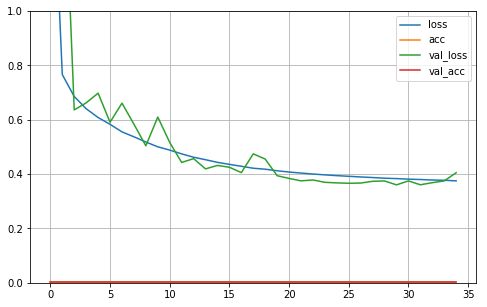

In [29]:
loss_value, accuracy = (model.evaluate([X_test_scaled_A, X_test_scaled_B], y_test))
print(f"loss_value={loss_value}, accuracy={accuracy}")
plot_learning_curves(history) 

### 7.3)
Now suppose you want to send only features 0 to 4 directly to the output, and only features 2 to 7 through the hidden layers, as shown on the following diagram. Use the functional API to build, train and evaluate this model.

**Tips**:
* You need to create two `keras.layers.Input` (`input_A` and `input_B`)
* Build the model using the functional API, as above, but when you build the `keras.models.Model`, remember to set `inputs=[input_A, input_B]`
* When calling `fit()`, `evaluate()` and  `predict()`, instead of passing `X_train_scaled`, pass `(X_train_scaled_A, X_train_scaled_B)` (two NumPy arrays containing only the appropriate features copied from `X_train_scaled`).

<img src="images/multiple_inputs.png" title="Multiple inputs" width=300 />

In [32]:
X_train_scaled_A = X_train_scaled[:, :5]
X_train_scaled_B = X_train_scaled[:, 2:]
X_valid_scaled_A = X_valid_scaled[:, :5]
X_valid_scaled_B = X_valid_scaled[:, 2:]
X_test_scaled_A = X_test_scaled[:, :5]
X_test_scaled_B = X_test_scaled[:, 2:]

In [35]:
def build_model(n_hidden=1, n_neurons=100, learning_rate=0.001):
    input_A_layer = keras.layers.Input(shape=[4 - 0 + 1])
    input_B_layer = keras.layers.Input(shape=[7 - 2 + 1])
    
    hidden1_layer = keras.layers.Dense(30, activation="relu")(input_B_layer)
    hidden2_layer = keras.layers.Dense(30, activation="relu")(hidden1_layer)
    
    concat_layers = keras.layers.concatenate([input_A_layer, hidden2_layer])
    output_layer = keras.layers.Dense(1)(concat_layers)
    
    model = keras.models.Model(inputs=[input_A_layer, input_B_layer], outputs=[output_layer])
    
    model.compile(loss='mse',
                  optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
                  metrics=['accuracy'])
    
    history = model.fit([X_train_scaled_A, X_train_scaled_B], y_train, epochs=100, 
                        validation_data=([X_valid_scaled_A, X_valid_scaled_B], y_valid),
                        callbacks=[keras.callbacks.EarlyStopping(patience=5)])
    
    return model

In [36]:
model = build_model()

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610==============================] - 1s 66us/sample - loss: 2.4776 - acc: 0.0026 - val_loss: 7.2436 - val_acc: 0.0044
Epoch 2/100
11610/11610==============================] - 0s 41us/sample - loss: 0.8997 - acc: 0.0029 - val_loss: 1.3492 - val_acc: 0.0044
Epoch 3/100
11610/11610==============================] - 1s 45us/sample - loss: 0.7108 - acc: 0.0028 - val_loss: 1.0039 - val_acc: 0.0044
Epoch 4/100
11610/11610==============================] - 1s 43us/sample - loss: 0.6480 - acc: 0.0028 - val_loss: 0.8183 - val_acc: 0.0044
Epoch 5/100
11610/11610==============================] - 0s 40us/sample - loss: 0.6062 - acc: 0.0028 - val_loss: 0.7016 - val_acc: 0.0044
Epoch 6/100
11610/11610==============================] - 0s 41us/sample - loss: 0.5729 - acc: 0.0028 - val_loss: 0.6275 - val_acc: 0.0044
Epoch 7/100
11610/11610==============================] - 0s 40us/sample - loss: 0.5445 - acc: 0.0028 - val_loss: 0.5720 - v

In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 30)           210         input_8[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 30)           930         dense_18[0][0]                   
____________________________________________________________________________________________

5160/5160==============================] - 0s 16us/sample - loss: 0.4037 - acc: 0.0019
loss_value=0.4036573244619739, accuracy=0.0019379844889044762


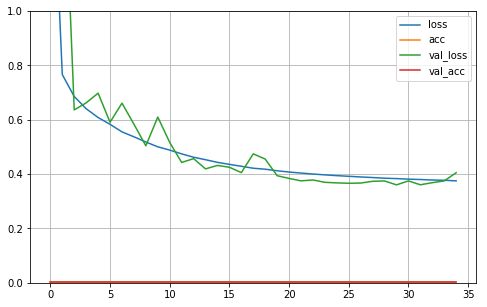

In [39]:
loss_value, accuracy = (model.evaluate([X_test_scaled_A, X_test_scaled_B], y_test))
print(f"loss_value={loss_value}, accuracy={accuracy}")
plot_learning_curves(history) 

### 7.4)
Build the multi-input and multi-output neural net represented in the following diagram.

<img src="images/multiple_inputs_and_outputs.png" title="Multiple inputs and outputs" width=400 />

**Why?**

There are many use cases in which having multiple outputs can be useful:
* Your task may require multiple outputs, for example, you may want to locate and classify the main object in a picture. This is both a regression task (finding the coordinates of the object's center, as well as its width and height) and a classification task.
* Similarly, you may have multiple independent tasks to perform based on the same data. Sure, you could train one neural network per task, but in many cases you will get better results on all tasks by training a single neural network with one output per task. This is because the neural network can learn features in the data that are useful across tasks.
* Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model's ability to generalize). For example, you may want to add some auxiliary outputs in a neural network architecture (as shown in the diagram) to ensure that that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

**Tips**:
* Building the model is pretty straightforward using the functional API. Just make sure you specify both outputs when creating the `keras.models.Model`, for example `outputs=[output, aux_output]`.
* Each output has its own loss function. In this scenario, they will be identical, so you can either specify `loss="mse"` (this loss will apply to both outputs) or `loss=["mse", "mse"]`, which does the same thing.
* The final loss used to train the whole network is just a weighted sum of all loss functions. In this scenario, you want most to give a much smaller weight to the auxiliary output, so when compiling the model, you must specify `loss_weights=[0.9, 0.1]`.
* When calling `fit()` or `evaluate()`, you need to pass the labels for all outputs. In this scenario the labels will be the same for the main output and for the auxiliary output, so make sure to pass `(y_train, y_train)` instead of `y_train`.
* The `predict()` method will return both the main output and the auxiliary output.

In [40]:
def build_model(n_hidden=1, n_neurons=100, learning_rate=0.001):
    input_A_layer = keras.layers.Input(shape=[4 - 0 + 1])
    input_B_layer = keras.layers.Input(shape=[7 - 2 + 1])
    
    hidden1_layer = keras.layers.Dense(30, activation="relu")(input_B_layer)
    hidden2_layer = keras.layers.Dense(30, activation="relu")(hidden1_layer)
    
    concat_layers = keras.layers.concatenate([input_A_layer, hidden2_layer])
    output_layer = keras.layers.Dense(1)(concat_layers)
    aux_output_layer = keras.layers.Dense(1)(hidden2_layer)
    
    model = keras.models.Model(inputs=[input_A_layer, input_B_layer],
                               outputs=[output_layer, aux_output_layer])
    
    model.compile(loss=["mse", "mse"],
                  loss_weights=[0.9, 0.1],
                  optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
                  metrics=['accuracy'])
    
    history = model.fit([X_train_scaled_A, X_train_scaled_B], [y_train, y_train], epochs=100, 
                        validation_data=([X_valid_scaled_A, X_valid_scaled_B], [y_valid, y_valid]),
                        callbacks=[keras.callbacks.EarlyStopping(patience=5)])
    
    return model

In [41]:
model = build_model()

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610==============================] - 1s 100us/sample - loss: 2.1696 - dense_23_loss: 1.9006 - dense_24_loss: 4.5860 - dense_23_acc: 0.0021 - dense_24_acc: 0.0013 - val_loss: 1.8833 - val_dense_23_loss: 1.7336 - val_dense_24_loss: 3.2256 - val_dense_23_acc: 0.0044 - val_dense_24_acc: 0.0039
Epoch 2/100
11610/11610==============================] - 1s 54us/sample - loss: 0.9433 - dense_23_loss: 0.7571 - dense_24_loss: 2.6201 - dense_23_acc: 0.0028 - dense_24_acc: 0.0029 - val_loss: 0.8667 - val_dense_23_loss: 0.7140 - val_dense_24_loss: 2.2400 - val_dense_23_acc: 0.0044 - val_dense_24_acc: 0.0044
Epoch 3/100
11610/11610==============================] - 1s 60us/sample - loss: 0.7860 - dense_23_loss: 0.6646 - dense_24_loss: 1.8791 - dense_23_acc: 0.0028 - dense_24_acc: 0.0029 - val_loss: 0.7608 - val_dense_23_loss: 0.6303 - val_dense_24_loss: 1.9389 - val_dense_23_acc: 0.0044 - val_dense_24_acc: 0.0044
Epoch 4/100
11610/11

11610/11610==============================] - 1s 60us/sample - loss: 0.4688 - dense_23_loss: 0.4257 - dense_24_loss: 0.8561 - dense_23_acc: 0.0027 - dense_24_acc: 0.0029 - val_loss: 0.4471 - val_dense_23_loss: 0.3991 - val_dense_24_loss: 0.8792 - val_dense_23_acc: 0.0044 - val_dense_24_acc: 0.0044
Epoch 28/100
11610/11610==============================] - 1s 62us/sample - loss: 0.4658 - dense_23_loss: 0.4242 - dense_24_loss: 0.8413 - dense_23_acc: 0.0027 - dense_24_acc: 0.0029 - val_loss: 0.4457 - val_dense_23_loss: 0.3980 - val_dense_24_loss: 0.8746 - val_dense_23_acc: 0.0044 - val_dense_24_acc: 0.0044
Epoch 29/100
11610/11610==============================] - 1s 49us/sample - loss: 0.4630 - dense_23_loss: 0.4224 - dense_24_loss: 0.8285 - dense_23_acc: 0.0027 - dense_24_acc: 0.0029 - val_loss: 0.4412 - val_dense_23_loss: 0.3941 - val_dense_24_loss: 0.8638 - val_dense_23_acc: 0.0044 - val_dense_24_acc: 0.0044
Epoch 30/100
11610/11610==============================] - 1s 52us/sample - loss:

11610/11610==============================] - 1s 53us/sample - loss: 0.4208 - dense_23_loss: 0.3971 - dense_24_loss: 0.6336 - dense_23_acc: 0.0027 - dense_24_acc: 0.0029 - val_loss: 0.4163 - val_dense_23_loss: 0.3923 - val_dense_24_loss: 0.6316 - val_dense_23_acc: 0.0044 - val_dense_24_acc: 0.0044


In [42]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 30)           210         input_10[0][0]                   
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 30)           930         dense_21[0][0]                   
____________________________________________________________________________________________

5160/5160==============================] - 0s 24us/sample - loss: 0.4133 - dense_23_loss: 0.3910 - dense_24_loss: 0.6165 - dense_23_acc: 0.0019 - dense_24_acc: 0.0021
[0.41333639145821566, 0.3910185, 0.6164802, 0.0019379845, 0.002131783]


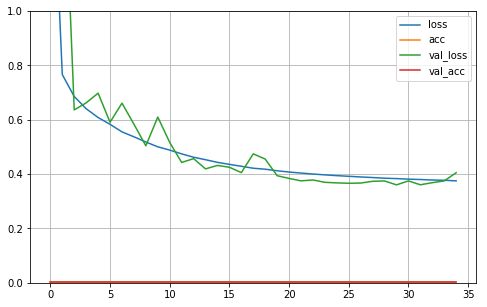

In [46]:
print(model.evaluate([X_test_scaled_A, X_test_scaled_B], [y_test, y_test]))
#print(f"loss_value={loss_value}, accuracy={accuracy}")
plot_learning_curves(history) 

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 7 – Solution

### 7.1)
Use Keras' functional API to implement a Wide & Deep network to tackle the California housing problem.

In [ ]:
input = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

In [ ]:
model = keras.models.Model(inputs=[input], outputs=[output])

In [ ]:
model.compile(loss="mean_squared_error", optimizer="sgd")

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
model.evaluate(X_test_scaled, y_test)

In [ ]:
model.predict(X_test_scaled)

### 7.2)
After the Sequential API and the Functional API, let's try the Subclassing API:
* Create a subclass of the `keras.models.Model` class.
* Create all the layers you need in the constructor (e.g., `self.hidden1 = keras.layers.Dense(...)`).
* Use the layers to process the `input` in the `call()` method, and return the output.
* Note that you do not need to create a `keras.layers.Input` in this case.
* Also note that `self.output` is used by Keras, so you should use another name for the output layer (e.g., `self.output_layer`).

In [ ]:
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden1 = keras.layers.Dense(30, activation="relu")
        self.hidden2 = keras.layers.Dense(30, activation="relu")
        self.output_ = keras.layers.Dense(1)

    def call(self, input):
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [ ]:
model.compile(loss="mse", optimizer="sgd")

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
model.summary()

In [ ]:
model.evaluate(X_test_scaled, y_test)

In [ ]:
model.predict(X_test_scaled)

### 7.3)
Now suppose you want to send only features 0 to 4 directly to the output, and only features 2 to 7 through the hidden layers, as shown on the diagram. Use the functional API to build, train and evaluate this model.

In [ ]:
input_A = keras.layers.Input(shape=[5])
input_B = keras.layers.Input(shape=[6])

In [ ]:
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)

In [ ]:
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [ ]:
model.compile(loss="mean_squared_error", optimizer="sgd")

In [ ]:
model.summary()

In [ ]:
X_train_scaled_A = X_train_scaled[:, :5]
X_train_scaled_B = X_train_scaled[:, 2:]
X_valid_scaled_A = X_valid_scaled[:, :5]
X_valid_scaled_B = X_valid_scaled[:, 2:]
X_test_scaled_A = X_test_scaled[:, :5]
X_test_scaled_B = X_test_scaled[:, 2:]

In [ ]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], y_train, epochs=10,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], y_valid))

In [ ]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], y_test)

In [ ]:
model.predict([X_test_scaled_A, X_test_scaled_B])

### 7.4)
Build the multi-input and multi-output neural net represented in the diagram.

In [ ]:
input_A = keras.layers.Input(shape=X_train_scaled_A.shape[1:])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)
aux_output = keras.layers.Dense(1)(hidden2)

In [ ]:
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [ ]:
model.compile(loss="mean_squared_error", loss_weights=[0.9, 0.1],
              optimizer="sgd")

In [ ]:
model.summary()

In [ ]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], [y_train, y_train], epochs=10,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], [y_valid, y_valid]))

In [ ]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], [y_test, y_test])

In [ ]:
y_pred, y_pred_aux = model.predict([X_test_scaled_A, X_test_scaled_B])

In [ ]:
y_pred

In [ ]:
y_pred_aux

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 8 – Deep Nets

Let's go back to Fashion MNIST and build deep nets to tackle it. We need to load it, split it and scale it.

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

### 8.1)
Build a sequential model with 20 hidden dense layers, with 100 neurons each, using the ReLU activation function, plus the output layer (10 neurons, softmax activation function). Try to train it for 10 epochs on Fashion MNIST and plot the learning curves. Notice that progress is very slow.

In [ ]:
model = keras.models.Sequential(layers=
                                [keras.layers.Flatten(input_shape=[28, 28])] + \
                                [keras.layers.Dense(units=100, activation='relu') for _ in range(20)] + \
                                [keras.layers.Dense(units=10, activation='softmax')]
)

In [ ]:
initial_weights = model.get_weights()

In [ ]:
model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
%time history = (model.fit(X_train_scaled, y_train, epochs=30, validation_data=(X_valid_scaled, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=5)]))

model.evaluate(X_test_scaled, y_test)

In [ ]:
plot_learning_curves(history)

### 8.2)
Update the model to add a `BatchNormalization` layer after every hidden layer. Notice that performance progresses much faster per epoch, although computations are much more intensive. Display the model summary and notice all the non-trainable parameters (the scale $\gamma$ and offset $\beta$ parameters).

In [ ]:
from functools import reduce #python 3

model = keras.models.Sequential(layers=
                                [keras.layers.Flatten(input_shape=[28, 28], name='input')] + \
                                reduce(lambda x,y: x + y, [[
                                    keras.layers.Dense(units=100, activation='relu', name=f"hidden_{i}"),
                                    keras.layers.BatchNormalization(name=f"batch_norm_{i}"),
                                    keras.layers.Activation("relu", name=f"activation_{i}")] for i in range(20)]) + \
                                [keras.layers.Dense(units=10, activation='softmax', name='output')]
)

In [ ]:
initial_weights = model.get_weights()

In [ ]:
model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
%time history = (model.fit(X_train_scaled, y_train, epochs=30, validation_data=(X_valid_scaled, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=5)]))

model.evaluate(X_test_scaled, y_test)

In [ ]:
plot_learning_curves(history)

### 8.3)
Try moving the BN layers before the hidden layers' activation functions. Does this affect the model's performance?

In [ ]:
from functools import reduce #python 3

model = keras.models.Sequential(layers=
                                [keras.layers.Flatten(input_shape=[28, 28], name='input')] + \
                                reduce(lambda x,y: x + y, [[
                                    keras.layers.BatchNormalization(name=f"batch_norm_{i}"),
                                    keras.layers.Activation("relu", name=f"activation_{i}"),
                                    keras.layers.Dense(units=100, activation='relu', name=f"hidden_{i}")]
                                    for i in range(20)]) + \
                                [keras.layers.Dense(units=10, activation='softmax', name='output')]
)

In [ ]:
initial_weights = model.get_weights()

In [ ]:
model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
%time history = (model.fit(X_train_scaled, y_train, epochs=30, validation_data=(X_valid_scaled, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=5)]))

model.evaluate(X_test_scaled, y_test)

In [ ]:
plot_learning_curves(history)

### 8.4)
Remove all the BN layers, and just use the SELU activation function instead. Notice that you get better performance than with BN but training is much faster. Isn't it marvelous? :-)

In [ ]:
model = keras.models.Sequential(layers=
                                [keras.layers.Flatten(input_shape=[28, 28])] + \
                                [keras.layers.Dense(units=100, activation='selu') for _ in range(20)] + \
                                [keras.layers.Dense(units=10, activation='softmax')]
)

In [ ]:
initial_weights = model.get_weights()

In [ ]:
model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
%time history = (model.fit(X_train_scaled, y_train, epochs=30, validation_data=(X_valid_scaled, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=5)]))

model.evaluate(X_test_scaled, y_test)

In [ ]:
plot_learning_curves(history)

### 8.5)
Try training for 10 additional epochs, and notice that the model starts overfitting. Try adding a Dropout layer (with a 50% dropout rate) just before the output layer. Does it reduce overfitting? What about the final validation accuracy?

**Warning**: you should not use regular Dropout, as it breaks the self-normalizing property of the SELU activation function. Instead, use AlphaDropout, which is designed to work with SELU.

In [ ]:
model = keras.models.Sequential(layers=
                                [keras.layers.Flatten(input_shape=[28, 28])] + \
                                [keras.layers.Dense(units=100, activation='selu') for _ in range(20)] + \
                                [keras.layers.AlphaDropout(rate=0.5),
                                 keras.layers.Dense(units=10, activation='softmax')]
)

In [ ]:
initial_weights = model.get_weights()

In [ ]:
model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
%time history = (model.fit(X_train_scaled, y_train, epochs=30, validation_data=(X_valid_scaled, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=5)]))

model.evaluate(X_test_scaled, y_test)

In [ ]:
plot_learning_curves(history)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 8 – Solution

### 8.1)
Build a sequential model with 20 hidden dense layers, with 100 neurons each, using the ReLU activation function, plus the output layer (10 neurons, softmax activation function). Try to train it for 10 epochs on Fashion MNIST and plot the learning curves. Notice that progress is very slow.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.2)
Update the model to add a `BatchNormalization` layer after every hidden layer. Notice that performance progresses much faster per epoch, although computations are much more intensive. Display the model summary and notice all the non-trainable parameters (the scale $\gamma$ and offset $\beta$ parameters).

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

In [ ]:
model.summary()

### 8.3)
Try moving the BN layers before the hidden layers' activation functions. Does this affect the model's performance?

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.4)
Remove all the BN layers, and just use the SELU activation function instead. Notice that you get better performance than with BN but training is much faster. Isn't it marvelous? :-)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.5)
Try training for 10 additional epochs, and notice that the model starts overfitting. Try adding a Dropout layer (with a 50% dropout rate) just before the output layer. Does it reduce overfitting? What about the final validation accuracy?

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)